In [1]:
import sys
sys.path.append('/app')
sys.path.append('/app/submodules/gaussian-splatting/')
sys.path.append('/app/submodules/gaussian-splatting/submodules/')
sys.path.append('/app/submodules/gaussian-splatting/submodules/diff-gaussian-rasterization/')
sys.path.append('/app/submodules/gaussian-splatting/submodules/simple-knn/')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
from random import randint
from utils.loss_utils import l1_loss, ssim
from gaussian_renderer import render, network_gui
import sys
from scene import Scene, GaussianModel
from utils.general_utils import safe_state
import uuid
from tqdm import tqdm
from utils.image_utils import psnr
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams

In [4]:
try:
    import lovely_tensors as lt
except:
    ! pip install --upgrade lovely-tensors
    import lovely_tensors as lt
    
lt.monkey_patch()

In [10]:
from dataclasses import dataclass, field
import os

@dataclass
class ModelParams:
    sh_degree: int = 3
    source_path: str = "/app/data/custom_datasets/cow_synthetic_gtdepth/"
    model_path: str = ""
    images: str = "images"
    resolution: int = -1
    white_background: bool = True#False
    data_device: str = "cuda"
    eval: bool = False

    def post_init(self):
        self.source_path = os.path.abspath(self.source_path)

@dataclass
class PipelineParams:
    convert_SHs_python: bool = False
    compute_cov3D_python: bool = False
    debug: bool = False

@dataclass
class OptimizationParams:
    iterations: int = 30_000
    position_lr_init: float = 0.00016
    position_lr_final: float = 0.0000016
    position_lr_delay_mult: float = 0.01
    position_lr_max_steps: int = 30_000
    feature_lr: float = 0.0025
    opacity_lr: float = 0.05
    scaling_lr: float = 0.005
    rotation_lr: float = 0.001
    percent_dense: float = 0.01
    lambda_dssim: float = 0.2
    densification_interval: int = 100
    opacity_reset_interval: int = 3000
    densify_from_iter: int = 500
    densify_until_iter: int = 15_000
    densify_grad_threshold: float = 0.0002

@dataclass
class TrainingArgs:
    ip: str = "0.0.0.0"
    port: int = 6007
    debug_from: int = -1
    detect_anomaly: bool = False
    test_iterations: list[int] = field(default_factory=lambda: [7_000, 30_000])
    save_iterations: list[int] = field(default_factory=lambda: [7_000, 30_000])
    quiet: bool = False
    checkpoint_iterations: list[int] = field(default_factory=lambda: [7_000, 15_000, 30_000])
    start_checkpoint: str = None
    
dataset = ModelParams()
opt = OptimizationParams()
pipe = PipelineParams()
args = TrainingArgs()

testing_iterations = args.test_iterations
saving_iterations = args.save_iterations 
checkpoint_iterations = args.checkpoint_iterations 
checkpoint = args.start_checkpoint
debug_from = args.debug_from

In [11]:
gaussians = GaussianModel(dataset.sh_degree)
scene = Scene(dataset, gaussians)
gaussians.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Loading Training Cameras
Loading Test Cameras
0.4980392156862745
Number of points at initialisation :  100000


Training progress:  13%|███████████████▌                                                                                                           | 3810/30000 [00:39<02:52, 152.21it/s, Loss=0.0031324]

In [7]:
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

In [8]:
iter_start = torch.cuda.Event(enable_timing = True)
iter_end = torch.cuda.Event(enable_timing = True)

In [9]:
viewpoint_stack = None
ema_loss_for_log = 0.0
first_iter = 0
progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")
first_iter += 1
for iteration in range(first_iter, opt.iterations + 1):
    iter_start.record()
    gaussians.update_learning_rate(iteration)
    
    # Every 1000 its we increase the levels of SH up to a maximum degree
    if iteration % 1000 == 0:
        gaussians.oneupSHdegree()
        
    # Pick a random Camera
    if not viewpoint_stack:
        viewpoint_stack = scene.getTrainCameras().copy()
    viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
    
    # Render
    if (iteration - 1) == debug_from:
        pipe.debug = True
    render_pkg = render(viewpoint_cam, gaussians, pipe, background)
    image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

    # Loss
    gt_image = viewpoint_cam.original_image.cuda()
    Ll1 = l1_loss(image, gt_image)
    loss = (1.0 - opt.lambda_dssim) * Ll1 + opt.lambda_dssim * (1.0 - ssim(image, gt_image))
    loss.backward()
    iter_end.record()
    
    with torch.no_grad():
        ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
        if iteration % 10 == 0:
            progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
            progress_bar.update(10)
        if iteration == opt.iterations:
            progress_bar.close()

        # # Log and save
        # training_report(tb_writer, iteration, Ll1, loss, l1_loss, iter_start.elapsed_time(iter_end), testing_iterations, scene, render, (pipe, background))
        # if (iteration in saving_iterations):
        #     print("\n[ITER {}] Saving Gaussians".format(iteration))
        #     scene.save(iteration)

        # Densification
        if iteration < opt.densify_until_iter:
            # Keep track of max radii in image-space for pruning
            gaussians.max_radii2D[visibility_filter] = torch.max(gaussians.max_radii2D[visibility_filter], radii[visibility_filter])
            gaussians.add_densification_stats(viewspace_point_tensor, visibility_filter)

            if iteration > opt.densify_from_iter and iteration % opt.densification_interval == 0:
                size_threshold = 20 if iteration > opt.opacity_reset_interval else None
                gaussians.densify_and_prune(opt.densify_grad_threshold, 0.005, scene.cameras_extent, size_threshold)

            if iteration % opt.opacity_reset_interval == 0 or (dataset.white_background and iteration == opt.densify_from_iter):
                gaussians.reset_opacity()
                
        # Optimizer step
        if iteration < opt.iterations:
            gaussians.optimizer.step()
            gaussians.optimizer.zero_grad(set_to_none = True)

        if (iteration in checkpoint_iterations):
            print("\n[ITER {}] Saving Checkpoint".format(iteration))
            torch.save((gaussians.capture(), iteration), scene.model_path + "/chkpnt" + str(iteration) + ".pth")
    
    if iteration > 15_000: break

Training progress:  13%|███████████████▌                                                                                                           | 3810/30000 [00:26<02:52, 152.21it/s, Loss=0.0031324]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x764c4be0de10>>
Traceback (most recent call last):
  File "/opt/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

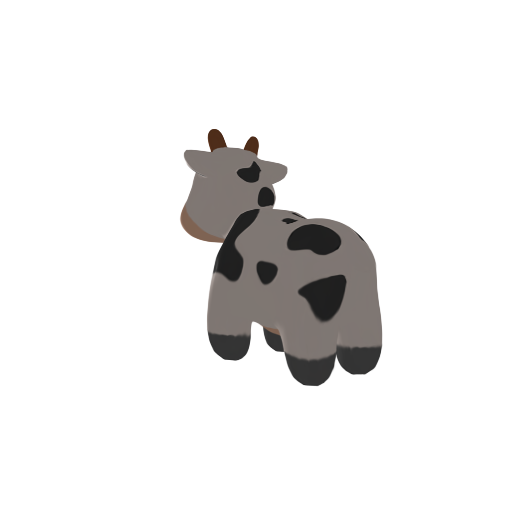

In [29]:
import random
cameras = scene.getTrainCameras().copy()

with torch.inference_mode():
    viewpoint_cam = random.choice(cameras)
    render_pkg = render(viewpoint_cam, gaussians, pipe, background)
    image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]
    
image.rgb